In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import DenseNet121 #Densenet121 모델 사용
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
#서버용 그래픽 카드 지정
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

In [3]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(48, 48, 3)) #채널이 무조건 3개여야 하며 크기는 최소 32 이상

x=model_d.output

x= GlobalAveragePooling2D()(x) #전역 평균 풀링 레이어 추가
x= BatchNormalization()(x) #배치 정규화 레이어
x= Dropout(0.2)(x)
#Fully Connected 레이어 추가
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.2)(x) #과적합 감소용 드롭아웃 레이어

preds=Dense(6,activation='softmax')(x) #FC-layer. 클래스가 7개이므로 softmax 7개 설정

In [4]:
model=Model(inputs=model_d.input,outputs=preds) 
model.summary() #모델 요약

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [5]:
#Freeze
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) #모델 생성
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 24, 24, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [7]:
data=[] #데이터
labels=[] #라벨
random.seed(42)
imagePaths = sorted(list(os.listdir("./input/emotion-project-2/train/"))) #데이터셋 경로
random.shuffle(imagePaths) #셔플
print(imagePaths)
#이미지 읽기 및 라벨링
for img in imagePaths:
    path=sorted(list(os.listdir("./input/emotion-project-2/train/"+img)))
    for i in path:
        image = cv2.imread("./input/emotion-project-2/train/"+img+'/'+i) #이미지 읽기
        image = cv2.resize(image, (48,48)) #이미지 사이즈 편집
        image = img_to_array(image) #이미지 배열화
        data.append(image) #data 배열에 데이터 추가
        l = label = img
        labels.append(l) #labels 배열에 데이터 추가

['neutral', 'fear', 'happy', 'sad', 'angry', 'surprise']


In [8]:
data = np.array(data, dtype="float32") / 255.0 #데이터 타입 변경 및 numpy 배열화
labels = np.array(labels) #라벨 numpy 배열화
mlb = LabelBinarizer() #데이터 전처리(원핫인코딩)
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [9]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42) #train용과 test용으로 데이터셋 분리
print(xtrain.shape, xtest.shape)

(38167, 48, 48, 3) (25446, 48, 48, 3)


In [10]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)


datagen.fit(xtrain)
# 모델 학습
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=64),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=100,
               verbose=2,    
               validation_data=(xtest, ytest))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
298/298 - 25s - loss: 1.7986 - accuracy: 0.3352 - val_loss: 1.5094 - val_accuracy: 0.4122
Epoch 2/100
298/298 - 24s - loss: 1.5804 - accuracy: 0.3809 - val_loss: 1.4714 - val_accuracy: 0.4223
Epoch 3/100
298/298 - 24s - loss: 1.5323 - accuracy: 0.3958 - val_loss: 1.4712 - val_accuracy: 0.4243
Epoch 4/100
298/298 - 24s - loss: 1.5102 - accuracy: 0.4066 - val_loss: 1.4299 - val_accuracy: 0.4357
Epoch 5/100
298/298 - 23s - loss: 1.4713 - accuracy: 0.4238 - val_loss: 1.4180 - val_accuracy: 0.4492
Epoch 6/100
298/298 - 24s - loss: 1.4623 - accuracy: 0.4222 - val_loss: 1.3908 - val_accuracy: 0.4552
Epoch 7/100
298/298 - 23s - loss: 1.4439 - accuracy: 0.4352 - val_loss: 1.3854 - val_accuracy: 0.4581
Epoch 8/100
298/298 - 24s - loss: 1.4394 - accuracy: 0.4361 - val_loss: 1.3994 - val_accuracy: 0.4491
Epoch 9/100
298/298 - 23s - loss: 1.4172 - accuracy: 0.4465 - val_loss: 1.3744 - val_accuracy: 0.4615
Epoch 

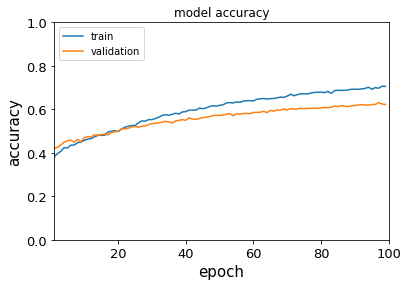

In [11]:
plt.title("model accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [12]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 25446 	accurately-predicted-data: 15843 	 wrongly-predicted-data:  9603
Accuracy: 62.261 %
